Hello Everyone,

I would like to share my learning on various quick and efficient ways of dealing with the problem of data loading for large datasets.

Hope you would like it!

While working with data, I hope everyone usually started with Jupyter notebooks running either on local system or cloud platform and the exceptional pandas library to read data files and transform them into various summaries of interest. We all are familiar with the awesome functionality and tools that it brings to data processing. My usual process would start with a text file with data in a CSV format. I would read data into a pandas DataFrame and run various transformations of interest. It is a very straightforward process for small datasets which you can store as plain-text files without too much overhead.
However, when the number of observations increases, the process of saving and loading data back into the memory becomes slower, and now each kernel’s restart steals your time and forces you to wait until the data reloads. So eventually, the CSV files or any other plain-text formats lose their attractiveness. But there are various ways where we can avoid this delay and utilize the computation power efficiently.

> **Quick Summary**

We would start discussing from general data loading and saving approach to the new data loading/saving approaches where we would fully utilize the multiprocessing concept(make use of all the IDLE CPU cores), which actually helps in faster computation. The below mentioned approcahes has it pros and cons and i would like you to explore all the approaches and choose whichever suits you requirements.

* A) Pandas Dataframe
* B) Pandas Dataframe + Using pandas chunksize, engine, iterator and memory_map parameter (saves memory)
* C) Dask Dataframe
* D) Datatable Library
* E) Modin-Dask/Ray Library
* F) Other Parallel Processing Libraries including swifter, pandaral-lel, dispy, multiprocessing, joblib and many more.
* G) Save And Load Data Using Various Data Formats

Besides it,there are plenty of binary formats to store the data which consumes less memory space and helps in faster task execution, which we would see in section G. These are:
* csv (default)
* feather
* hdf
* msgpack
* parquet
* pickle
* jay
* numpy array(.npy format) - for numerical data

In [ ]:
# import the library
import gc
import numpy as np
import pandas as pd
import os
import time
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')

I would be working on [*nfl_big_data_bowl_2021*](https://www.kaggle.com/c/nfl-big-data-bowl-2021/data) dataset for this demo notebook. (~2.2 Gb in size). Lets load the data.

In [ ]:
%%time
path = "/kaggle/input/nfl-big-data-bowl-2021/"
# I am using a function to avoid any kind of additional unnecassary variable - helps in RAM saving
# As this creates a new scope for the intermediate variables 
# and removes them automatically when the interpreter exits the function.
# Note: I am using 50e5 rows because of memory limitation on Kaggle platform
def load_data():
    weekly_data = [csv for csv in os.listdir(path) if csv[:5] == "week1"]
    # selecting data for all the weeks having "1" in week name and using 20e5 rows due to the memory limitation of Kaggle notebook.
    # As only 16 gigs is allowed to use.
    dataframe = pd.DataFrame()
    for files in weekly_data:
        df = pd.read_csv(filepath_or_buffer = "/kaggle/input/nfl-big-data-bowl-2021/%s"%files, nrows=3000000)
        dataframe = pd.concat([dataframe,df])
    return dataframe[:]

dataframe = load_data()


# A) General Approach To Save And Load Data - Using Pandas CSV
* **Saving into the CSV Format**

In [ ]:
%%time
# Saving data in CSV Format 
dataframe.to_csv("/kaggle/working/csv_data.csv",index = False) 

* **Reading the CSV Data**

In [ ]:
%%time
# Reading data in CSV Format 
csv_data = pd.read_csv("/kaggle/working/csv_data.csv")

In [ ]:
del dataframe #we won't use this dataframe so i am deleting those to free up some space.
del csv_data
gc.collect() # collect garbage value from the memory

As we can see above that data saving and data loading really took a lot of time.
Let's try improve it.

# B) Using pandas chunksize, engine, iterator and memory_map parameter.
The following parameters proved helpful in enhancing the preformance. You can play with them.
* **chunksize:** Sometimes, while loading/reading data, because of the system's memory limitation(Limited RAM) we may encounter *MemoryError*.
Well the good news is we can can read the larger data files in smaller chunks in pandas. pandas **read_csv** has an inbuilt paramenter "**chunksize**", which does read the data in chunks. Meaning,the number of rows to be read into a dataframe at any single time in order to fit into the local memory. Using *chunksize* would result in **TextFileReader object** for iteration. We can perform operation on each chunk and concatenate each of them to form a dataframe as shown below to fit into the local memory.
* **engine:** 'c' and 'python' engines. It's an optional parameter. The names indicate the language in which the parsers are written. Pandas uses the C parser (specified as engine='c') whereever possible, but may fall back to Python if C-unsupported options are specified.
> *The main intent is to use "C" engine whenever we can use because C engine is faster.*
More Info: https://stackoverflow.com/questions/52774459/engines-in-python-pandas-read-csv
* **iterator:** Produces a series of values over time (TextfileReader objects), rather than computing them at once. Saves memory.
* **memory_map:** Maps the file object directly onto memory and access the data directly from there.

In [ ]:
%%time
# let's define a function to avoid creating unnecessary variable
def load_data_chunk(filepath, chunksize =500000, iterator = True, engine = 'c', memory_map = True):
    chunk_df = [x for x in pd.read_csv(filepath_or_buffer = filepath,nrows=3000000, chunksize=chunksize, iterator=iterator, engine=engine, memory_map= memory_map)]
    chunk_data = pd.concat(chunk_df,sort=False)
    return chunk_data

chunk_data = load_data_chunk(filepath= "/kaggle/working/csv_data.csv")

This way *we can eliminate the MemoryError* but it comes with a price .i.e sometimes execution time can be a little bit more as compare to the general approach. But it proves faster than the default pandas.read_csv approach.

In [ ]:
del chunk_data # we won't use this dataframe so i am deleting those to free up some space.
gc.collect() # collect garbage value from the memory

# **C) Using Dask DataFrame**
> In Layman's term, [dask](https://docs.dask.org/en/latest/why.html) is basically a parallel computing library where we can analyze csv data without loading the whole csv into the memory and we can perform faster computation by on single machines by leveraging their multi-core CPUs (idle cpu cores) and streaming data efficiently from disk.

A Dask DataFrame is composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. 
> The best part about dask or dask dataframe is that we can use this library just like we do use pandas library as the dusk API is built on top of pandas API.

We can use Dask Library in the following cases:
* Manipulating large datasets, even when those datasets don’t fit in memory
* Accelerating long computations by using many cores
* Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

Note: **Data transformation** can not utilize the perk of parallel computation.

In [ ]:
# !pip install dask[complete] --> for complete installation
!pip install dask # installing dask
# import dask dataframe
import dask.dataframe as dd

> Note: From now onwards we would use Dask Library instead of Pandas library for the demo.

As i already mentioned the Dask APIs is a subset of Pandas API, so we can use the same methods like we do use in pandas. Now we will replicate the data saving and loading/reading (like we did use Pandas above) using Dask library.
> **Prepare Data:** Instead of "pd" we would use "dd". Other than this everything would be same below.

In [ ]:
%%time
# Reading data in CSV Format using Dask Dataframe 
dask_csv_data = dd.read_csv(urlpath= "/kaggle/working/csv_data.csv")
dask_csv_data.head(3)

Wow!, as we can see that above method using Dask Dataframe is really really fast. We can apply some of the quick data manipulation methods as shown in below cells:

In [ ]:
dask_csv_data.columns

In [ ]:
dask_csv_data.shape

As we can see above we are unable to get the total rows in a dataframe. The Dask delayed function decorates your functions so that they operate lazily. Rather than executing your function immediately, it will defer execution, placing the function and its arguments into a task graph.

So we can turn any dask collection into a concrete value by calling the **.compute()** method or **dask.compute(...)** function. This function will block until the computation is finished, going straight from a lazy dask collection to a concrete value in local memory.

In [ ]:
del dask_csv_data
gc.collect()

In [ ]:
%%time
# Reading data in CSV Format using Dask Dataframe 
dask_csv_data = dd.read_csv(urlpath= "/kaggle/working/csv_data.csv", blocksize= 64e6).compute()  # 64MB chunks 
dask_csv_data.head(3)

In [ ]:
%%time
# Storing data in CSV Format - using dask
dask_csv_data.to_csv("/kaggle/working/dask_data.csv",index = False)

In [ ]:
del dask_csv_data # free up some space.
gc.collect() # collect garbage value from the memory

For the above method we can conclude that data saving took time but data reading is comparatively faster. You can play around with different dataset and check the results.

# D) Datatable Library
[datatable](http://https://datatable.readthedocs.io/en/latest/manual/index-manual.html) provides fast and convenient parsing of text (csv) files. I recently came to know about this library and it proves helpful for me for data analysis. Thanks! to the [author](https://www.kaggle.com/rohanrao/riiid-with-blazing-fast-rid).

> Datatable is inspired by R's data.table which enhances the accessibility of data. It is faster than pandas.

The datatable parser
* Automatically detects separators, headers, column types, quoting rules, etc.
* Reads from file, URL, shell, raw text, archives, glob
* Provides multi-threaded file reading for maximum speed
* Includes a progress indicator when reading large files

In [ ]:
!pip install datatable # install datatable 
import datatable as dt # import datatable
print(f'Version: {dt.__version__}')

We would create a frame using **fread() function** which is both powerful and extremely fast. It can automatically detect parse parameters for the majority of text files, load data from .zip archives or URLs, read Excel files, and much more.

In [ ]:
%%time
frame = dt.fread("csv_data.csv")

In [ ]:
frame.head(2)

That was incredibly fast!
We can easily convert an existing Frame into a numpy array, a pandas DataFrame using **to_numpy** and  **to_pandas()** method respectively and perform the data manipulation like we do in pandas. 

Pretty fast and easy right?

In [ ]:
# %%time
# pandas_df = frame.to_pandas()
# pandas_df = dt.fread("csv_data.csv").to_pandas() # we can combine both the above steps
# pandas_df.head(2)

> We can also save the Frame into a **.jay** (binary) format on disk, then open it later instantly, regardless of the data size.

In [ ]:
%%time
# save data to .jay format
frame.to_jay("data_table.jay")

In [ ]:
%%time
#read the .jay data foramt
dt.open("data_table.jay").head(2) # we would get Frame
# -- we can easily covert frames to pandas dataframe directly
# jay_data = dt.open("data_table.jay").to_pandas()

In [ ]:
#del pandas_df# free up some space.
del frame
gc.collect() # collect garbage value from the memory

From the above results, we can conclude that datatable is really fast. Within seconds we can get the desired result.

# E) MODIN-DASK/RAY Library
[Modin Library](https://modin.readthedocs.io/en/latest/) is my personal favourite which i do use mostly along with datatable in jupyter notebook. During the process execution(either data manipulation or any kind of operatin) the system generally uses a single core/cpu and others are in idel state. Why not utilize the idle cores?

> The main idea is that it does utilize all the Idle CPU Cores which helps in computing faster.

* Modin is an early stage DataFrame library that wraps pandas and transparently distributes the data and computation, accelerating your pandas workflows with one line of code change. 
* The user does not need to know how many cores their system has, nor do they need to specify how to distribute the data. 
* In fact, users can continue using their previous pandas notebooks while experiencing a considerable speedup from Modin, even on a single machine. Only a modification of the import statement is needed. Once you’ve changed your import statement, you’re ready to use Modin just like you would pandas, since the API is identical to pandas.

> Modin uses **Ray or Dask** to provide an effortless way to speed up your pandas notebooks, scripts, and libraries.
* **[Ray](https://docs.ray.io/en/latest/)** is a fast, simple framework for building and running distributed applications. Ray leverages Apache Arrow for efficient data handling and provides task and actor abstractions for distributed computing.
* **[Dask](https://docs.dask.org/en/latest/)** provides advanced parallelism for analytics, enabling performance at scale. Dask focuses more on the data science world, providing higher-level APIs that in turn provide partial replacements for Pandas, NumPy, and scikit-learn, in addition to a low-level scheduling and cluster management framework.

The main difference between Dask and Ray is *Dask uses a centralized scheduler to share work across multiple cores, while Ray uses distributed bottom-up scheduling.

You can find this [link](https://www.datarevenue.com/en-blog/pandas-vs-dask-vs-vaex-vs-modin-vs-rapids-vs-ray#:~:text=Dask%20vs.-,Ray,parallel%20across%20clusters%20of%20machines.&text=Dask%20uses%20a%20centralized%20scheduler,uses%20distributed%20bottom%2Dup%20scheduling.) useful for more differences.

Note: Ray does not support Windows, so it will not be possible to install modin[ray] or modin[all].
* pip install modin[all] # Install all of the above
* pip install modin[ray] # Install Modin dependencies and Ray to run on Ray

In [ ]:
!pip install modin[dask] # Install Modin dependencies and Dask to run on Dask

# Initialize all cores- MODIN-DASK Engine
# import os - Uncomment this if in use.Already imported in top cell.
os.environ["MODIN_ENGINE"] = "dask"
from distributed import Client
client = Client()
import modin.pandas as mpd

*So instead of pandas pd we just have to use mpd i.e modin.pandas* and other format/methods would be same like pandas. Unlike in dask dataframe (refer section C above) we have some other methods (like .compute() and others) which we need for various operations or for data manupulation but here, in modin we don't need to care about any method/format, just use it like pandas library as Modin APIs are identical to Pandas APIs.

In [ ]:
%%time
# using default pandas method to prepare data
dataframe = load_data() # function load_data defined above

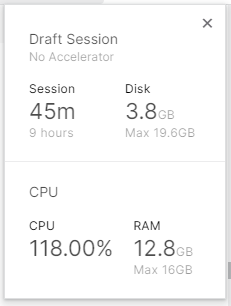
As you can see results for the above default pd method. Note the CPU utilization and time taken. Below we would be executing the same function but using MODIN.PANDAS.

In [ ]:
%%time
# changing the default pandas(pd) method by modin.pandas(mpd)
path = "/kaggle/input/nfl-big-data-bowl-2021/"
# I am using a function to avoid any kind of additional unnecassary variable - helps in RAM saving
# As this creates a new scope for the intermediate variables 
#  and removes them automatically when the interpreter exits the function.
def load_data_modin():
    weekly_data = [csv for csv in os.listdir(path) if csv[:5] == "week1"]
    # selecting data for all the weeks having "1" in week name due to the memory limitation of Kaggle notebook.
    # As only 16 gigs is allowed to use.
    dataframe = mpd.DataFrame()
    for files in weekly_data:
        df = mpd.read_csv(filepath_or_buffer = "/kaggle/input/nfl-big-data-bowl-2021/%s"%files)
        dataframe = mpd.concat([dataframe,df])
    return dataframe

dataframe_mpd = load_data_modin()

Did you see the runtime?.. Hurrah! Blazigly Fast :) We got our result in no time.

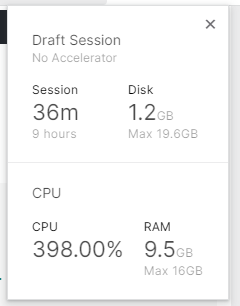

We can see the results now for the above operation i.e using modin.pandas(mpd). Please note the CPU utilization and time taken. Modin uses all the CPU cores for faster results. You can check the local CPU core performance in task manager just to cross check whether it's working or not.

**Conclusion:** From the above results i.e the time taken (approx 1/4 of the general approach) and CPU utilization, we can conclude that modin library works blazingly fast.

**Saving and Reading CSV data using modin.pandas**

In [ ]:
%%time
# Storing merged data in CSV Format 
dataframe_mpd.to_csv("/kaggle/working/modin_csv_data.csv",index = False)

In [ ]:
%%time
# Reading data in CSV Format 
csv_data = mpd.read_csv("/kaggle/working/csv_data.csv")

In [ ]:
del csv_data
gc.collect()

# F) Other Parallel Processing Libraries
You can play around with few others parallel processing libraries and see if they are helpful for you.
* [SWIFTER](https://github.com/jmcarpenter2/swifter/blob/master/docs/documentation.md): Swifter is a package that tries to efficiently apply any function to a Pandas Data Frame or Series object in the quickest available method. It is integrated with the Pandas object so that we would use this package only with a Pandas object such as Data Frame or Series.
Useful [Link](https://towardsdatascience.com/speed-up-your-pandas-processing-with-swifter-6aa314600a13)
* [Pandaral-lel](https://github.com/nalepae/pandarallel): The idea of Pandaral·lel is to distribute your pandas calculation over all available CPUs on your computer to get a significant speed increase  **Limitation of Pandaral-lel**: Pandaral-lel only works with pandas and for windows pc, Pandaral·lel would works only if the Python session (python, ipython, jupyter notebook, jupyter lab) is executed from [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/) (WSL). 
Useful [Link](https://towardsdatascience.com/pandaral-lel-a-simple-and-efficient-tool-to-parallelize-your-pandas-operations-on-all-your-cpus-bb5ff2a409ae).
* [Ipyparallel](http://people.duke.edu/~ccc14/sta-663-2016/19C_IPyParallel.html): This another multiprocessing and task-distribution system, specifically for parallelizing the execution of Jupyter notebook code across a cluster. We can use prefix %px in any Python statement to automatically parallelize it. Useful [Link](https://ipyparallel.readthedocs.io/en/latest/).
* [Dispy](http://dispy.sourceforge.net/): dispy is a generic, comprehensive and easy to use framework for creating and using compute clusters to execute computations in parallel across multiple processors in a single machine (SMP), among many machines in a cluster, grid or cloud. It lets you distribute whole Python programs or just individual functions across a cluster of machines for parallel execution. It uses platform-native mechanisms for network communication to keep things fast and efficient, so Linux, MacOS, and Windows machines work equally well.
* [Multiprocessing](https://docs.python.org/3/library/multiprocessing.html): We can use multi-processing package to process the input file in parallel to speed up processing.
* [Joblib](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html): Joblib provides a simple helper class to write parallel for loops using multiprocessing. The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing. Joblib basically uses the "Parallel" class to execute parallel tasks on CPU.

I would draft a seperate notebook with working examples having all the above methods to fasten/speed-up the computation tasks for data manipulation and analysis if you would like this notebook.

# G) Save And Load Data Using Various Data Formats
The above methods talks about reading/loading data in csv format to enhace the data manipulation/computation and eliminates the waiting time until the data loads into the memory upto a great extent. Besides it, it's always the best practice to save the dataset into various data formats which helps in faster data manipulation and consumes less memory. There are plenty of binary formats to store the data on disk, and many of them pandas supports. Useful [Link](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d).

We can convert our data into the following data formats:
* csv (default)
* feather
* hdf
* msgpack
* parquet
* pickle
* jay
* numpy array(.npy format) - for numerical data

Let's start......

# G1) csv format
A CSV is a comma-separated values file, which allows data to be saved in a tabular format. This is the default standard text file format that we are using from the beginning and mostly data is available in this format.

**A. Save And Load CSV using PANDAS**

In [ ]:
%%time
# We would be using pandas library
save = {} # creating an dict obj to store the data saving time
read = {} # creating an dict obj to save the data reading time

# load data
# dataframe_pandas  = load_data() and change to csv
# pandas "dataframe" is already defined above so we would be using this here.

# save the data
t1 = time.time() #initial time
dataframe.to_csv("df_csv.csv", index = False) # save df in .csv format
save["csv_pd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_csv = pd.read_csv("df_csv.csv")
read["csv_pd"] = time.time()-t2 # append the data to "read" dict

del dataframe

**B. Save And Load CSV Using Modin.Pandas**

In [ ]:
%%time
# We would be using modin.pandas library
# load data
# dataframe_pandas  = load_data_modin() and change to csv
# pandas "dataframe_mpd" is already defined above so we would be using that here.

#save the data
t1 = time.time() #initial time
dataframe_mpd.to_csv("df_csv.csv", index = False) # save dataframe in .csv format
save["csv_mpd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_csv_mpd = mpd.read_csv("df_csv.csv")
read["csv_mpd"] = time.time()-t2 # append the data to "read" dict

del dataframe_mpd
del df_csv_mpd # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G2) Feather Format
[Feather](https://arrow.apache.org/docs/python/feather.html#:~:text=Feather%20is%20a%20portable%20file,Python%20(pandas)%20and%20R.) is a fast, lightweight, and easy-to-use binary file format for storing data frames.“Feather” provides binary columnar serialization for data frames designed to make efficient reading and writing of data frames. It uses Apache Arrow columnar memory specification to represent binary data on disk. It has a few specific design goals:

* Lightweight, minimal API: make pushing data frames in and out of memory as simple as possible
* Language agnostic: Feather files are the same whether written by Python or R code. Other languages can read and write Feather files, too. 
* High read and write performance. Whenever possible, Feather operations should be bound by local disk performance.

Useful [Link](https://blog.rstudio.com/2016/03/29/feather/).


In [ ]:
%%time

#save the data
t1 = time.time() #initial time
df_csv.to_feather("df_csv") # save df in feather format
save["feather_pd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_feather = pd.read_feather("df_csv", use_threads = True)
read["feather_pd"] = time.time()-t2 # append the data to "read" dict

del df_feather # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G3) hdf Format
[Hierarchical Data Format (HDF)](https://www.hdfgroup.org/solutions/hdf5/) is a set of file formats (HDF4, HDF5) designed to store and organize large amounts of data. It supports an unlimited variety of datatypes, and is designed for flexible and efficient I/O and for high volume and complex data. It allows access time and storage space optimizations.
There is a shortcoming which i noticed that while reading the data, it consumes a lot of memory initially and then reset to normal state, which can cause MemoryError or can break the kernel if we won't have sufficient memory. 

In [ ]:
%%time

#save the data
t1 = time.time() #initial time
df_csv.to_hdf("df_csv.h5", key='hdf', mode='w') # save df in hdf format
save["hdf_pd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_hdf = pd.read_hdf("df_csv.h5", key = 'hdf')
read["hdf_pd"] = time.time()-t2 # append the data to "read" dict

del df_hdf # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G4) Parquet Format
[Parquet](https://parquet.apache.org/documentation/latest/) is an open source file format available to any project in the Hadoop ecosystem. Apache Parquet is designed for efficient as well as performant flat columnar storage format of data compared to row based files like CSV or TSV files.

Parquet uses the record shredding and assembly algorithm which is superior to simple flattening of nested namespaces. Parquet is optimized to work with complex data in bulk and features different ways for efficient data compression and encoding types.  This approach is best especially for those queries that need to read certain columns from a large table. Parquet can only read the needed columns therefore greatly minimizing the IO.

Useful [Link](https://www.upsolver.com/blog/apache-parquet-why-use)

In [ ]:
%%time

#save the data
t1 = time.time() #initial time
df_csv.to_parquet("df_csv.parquet.gzip", compression='gzip') # save df in parquet format
save["parquet_pd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_parquet = pd.read_parquet("df_csv.parquet.gzip")
read["parquet_pd"] = time.time()-t2 # append the data to "read" dict

del df_parquet # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G5) Pickle Format
We can save our data files in pickle format which works on serializing and de-serializing objects. The process to converts any kind of python objects (list, dict, etc.) into byte streams (0s and 1s) is called pickling or serialization or flattening or marshalling. We can converts the byte stream (generated through pickling) back into objects by a process called as unpickling.

In [ ]:
%%time

#save the data
t1 = time.time() #initial time
df_csv.to_pickle("df_csv.pkl") # save df in pkl format
save["pickle_pd"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_pickle = pd.read_pickle("df_csv.pkl")
read["pickle_pd"] = time.time()-t2 # append the data to "read" dict

del df_pickle # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G6) Msgpack Format
[MessagePack](https://msgpack.org/index.html) is an efficient binary serialization format. It lets you exchange data among multiple languages like JSON. But it's faster and smaller. Small integers are encoded into a single byte, and typical short strings require only one extra byte in addition to the strings themselves. This package provides CPython bindings (for python) for reading and writing MessagePack data.

We would be using **pandas-msgpack** library.
> The *pandas_msgpack* module provides an interface from [pandas](https://pandas.pydata.org) to the msgpack library. This is a lightweight portable binary format, similar to binary JSON, that is highly space efficient, and provides good performance both on the writing (serialization), and reading (deserialization).


In [ ]:
# Note: pandas-msgpack is not working in kaggle notebook -- facing some installation error
# but for me it does work in local machine.
# For the time being, i am leaving the code as it is.
!pip install pandas-msgpack -U
# to avoid error we need specific pandas version
!pip install pandas-compat
# !pip uninstall --yes pandas
!pip install --upgrade pandas
from pandas_msgpack import to_msgpack, read_msgpack

In [ ]:
%%time

#save the data
t1 = time.time() #initial time
to_msgpack('msgpack_dataframe.msg', df_csv)
save["msgpack"] = time.time()-t1 # append the data to "save" dict

#load the saved data
t2 = time.time()
df_msgpack = read_msgpack('msgpack_dataframe.msg')
read["msgpack"] = time.time()-t2 # append the data to "read" dict

del df_msgpack # delete the csv data to free memory space
gc.collect() # collect garbage value (if any) from the memory

# G7) Jay Format
As we already discussed about the datatable above(refer section D above for more info). Datatable is both powerful and extremely fast. We can use .jay format for faster data manipulation.

In [ ]:
%%time
print(f'Version: {dt.__version__}')  #datatable is already installed above

# save to .jay format
t1 = time.time() #initial time
frame = dt.fread("df_csv.csv")       #store data in datatable frame 
frame.to_jay("data_table.jay")       # change to .jay format
save["jay"] = time.time()-t1         # append the data to "save" dict

t2 = time.time()
jay_data = dt.open("data_table.jay")
read["jay"] = time.time()-t2          # append the data to "save" dict
# to covert to pandas dataframe directly
# jay_data = dt.open("data_table.jay").to_pandas() # because of limited memory - Commenting.


del frame
del jay_data       # delete the csv data to free memory space
gc.collect()       # collect garbage value (if any) from the memory

# G7) Numpy Format- For numerical dataset
Whenever dealing with numerical data, it's always a good practice to use [Numpy](https://numpy.org/devdocs/reference/generated/numpy.lib.format.html) File format as they are fast and easy to work with. It contains an array saved in the NumPy (NPY) file format. NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.
Useful [Link](https://www.kdnuggets.com/2018/04/start-using-npy-files-more-often.html)

In [ ]:
#select dataframe having numerical dtype (int/float)
numerical_df = df_csv.select_dtypes(include=['int64', 'float64'])
print(f"numerical_df memory info: {numerical_df.memory_usage().sum()/1024**2} MBs.")

In [ ]:
%%time
# save numerical data in .npy format
# np.save('data.npy', dataframe)
with open("data.npy", "wb") as file:
    np.save(file, numerical_df)

In [ ]:
%%time
# read numerical data in .npy format
# data_array = np.load('data.npy')
# data = pd.DataFrame(data_array)
with open("data.npy", "rb") as file:
    data = np.load(file)
df = pd.DataFrame(data)

We can see from the above results that NPY File format is blazingly fast for reading the numrical data.

In [ ]:
result_df = pd.DataFrame({'SaveTime(in sec)':pd.Series(save),'ReadTime(in sec)':pd.Series(read)})
result_df

# Conclusion
If your pc has several CPUs, only one is fully dedicated to your calculation. Why don't we use the Idle CPUs?
From the above experiments, one thing is clear that we can make use of the libraries that helps in parallel processing. They definitely boosts the performance and saves time. Beside it we can play with other approaches/libraries/methods as single approach/library/method would never fit for all scenarios. Every approach has it's own drawbacks and advantages. You can try with different datasets and see if the above methods proves benficial for you or not. There are plenty of binary formats to store the data which consumes less memory space and helps in faster task execution, hence we must utilize the perk of various data formats.

I hope the above methods would help you like they does help me.

Please feel free to share other methods. Feedbacks are welcome.

Thanks!